# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as sp
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller, kpss

from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from scipy import signal

# Load Data

In [2]:
climb_data = pd.read_csv("climbing_statistics.csv")
climb_data.head()

,Date,Route,Attempted,Succeeded,Success Percentage
0,11/27/2015,Disappointment Cleaver,2,0,0.0
1,11/21/2015,Disappointment Cleaver,3,0,0.0
2,10/15/2015,Disappointment Cleaver,2,0,0.0
3,10/13/2015,Little Tahoma,8,0,0.0
4,10-09-15,Disappointment Cleaver,2,0,0.0


# Data Exploration Climbing Statistics

In [3]:
climb_data.dtypes

Date                   object
Route                  object
Attempted               int64
Succeeded               int64
Success Percentage    float64
dtype: object

In [4]:
climb_data.isnull().values.any()

False

In [5]:
climb_data.shape

(4077, 5)

The date is listed as an object datatype, but it will need to be converted to a datetime type for analysis.

In [6]:
climb_data['Date'] = pd.to_datetime(climb_data['Date'])
climb_data.dtypes

Date                  datetime64[ns]
Route                         object
Attempted                      int64
Succeeded                      int64
Success Percentage           float64
dtype: object

In [7]:
climb_data['Date'].min(), climb_data['Date'].max()
#Start and end of date range

(Timestamp('2014-01-04 00:00:00'), Timestamp('2015-11-27 00:00:00'))

In [8]:
(climb_data['Date'].max() - climb_data['Date'].min()).days +1
# Number of days in data range

693

In [9]:
climb_data['Date'].nunique()

391

In [10]:
climb_data['Route'].nunique()

26

In [11]:
sorted(climb_data['Route'].unique())

['Curtis RIngraham Directge',
 'Disappointment Cleaver',
 'Edmonds HW',
 'Emmons-Winthrop',
 "Fuhrer's Finger",
 'Fuhrers Finger',
 'Gibralter Chute',
 'Gibralter Ledges',
 'Ingraham Direct',
 'Kautz Cleaver',
 'Kautz Glacier',
 'Kautz Headwall',
 'Liberty RIngraham Directge',
 'Liberty Wall',
 'Little Tahoma',
 'Mowich Face',
 'Nisqually Glacier',
 'Ptarmigan RIngraham Directge',
 'Success Cleaver',
 'Sunset Amphitheater',
 'Sunset RIngraham Directge',
 'Tahoma Cleaver',
 'Tahoma Glacier',
 'Unknown',
 'Wilson Headwall',
 'glacier only - no summit attempt']

'Fuhrer's Finger' and 'Fuhrers Finger' refer to the same route, 'Fuhrer Finger'. Other duplicate sounding names refer to different routes.

Note: 'Unknown' and 'glacier only - no summit attempt'. These may skew data.

In [12]:
climb_data.loc[(climb_data.Route == 'Fuhrers Finger'), 'Route'] = 'Fuhrer Finger'
climb_data.loc[(climb_data.Route == "Fuhrer's Finger"), 'Route'] = 'Fuhrer Finger'

In [13]:
climb_data.Route.value_counts()
# Disappointment Cleaver by far the most popular going by number of parties.

Disappointment Cleaver              2728
Emmons-Winthrop                      632
Kautz Glacier                        182
Fuhrer Finger                         92
Gibralter Ledges                      76
Little Tahoma                         70
Liberty RIngraham Directge            69
glacier only - no summit attempt      66
Ingraham Direct                       53
Unknown                               32
Ptarmigan RIngraham Directge          22
Kautz Cleaver                         14
Tahoma Glacier                        11
Success Cleaver                        6
Gibralter Chute                        5
Mowich Face                            4
Sunset RIngraham Directge              3
Curtis RIngraham Directge              2
Wilson Headwall                        2
Nisqually Glacier                      2
Edmonds HW                             2
Tahoma Cleaver                         1
Kautz Headwall                         1
Liberty Wall                           1
Sunset Amphithea

Text(0.5, 1.0, 'Number of Parties per Route')

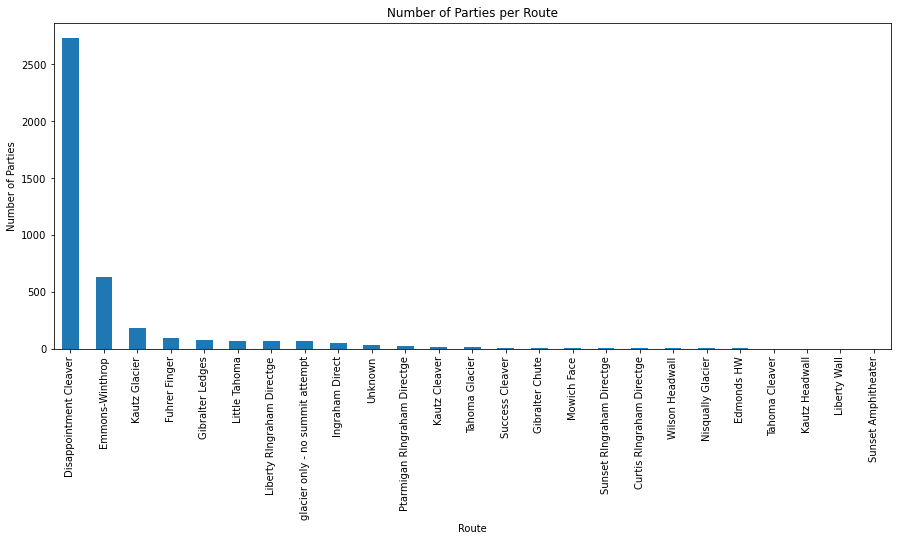

In [14]:
climb_data.Route.value_counts().plot(kind='bar', figsize=(15,6))
plt.ylabel('Number of Parties')
plt.xlabel('Route')
plt.title('Number of Parties per Route')

In [15]:
climb_data.head()

,Date,Route,Attempted,Succeeded,Success Percentage
0,2015-11-27,Disappointment Cleaver,2,0,0.0
1,2015-11-21,Disappointment Cleaver,3,0,0.0
2,2015-10-15,Disappointment Cleaver,2,0,0.0
3,2015-10-13,Little Tahoma,8,0,0.0
4,2015-10-09,Disappointment Cleaver,2,0,0.0


In [16]:
climb_data.rename(columns={'Attempted': 'Failed'}, inplace=True)
climb_data.head()

,Date,Route,Failed,Succeeded,Success Percentage
0,2015-11-27,Disappointment Cleaver,2,0,0.0
1,2015-11-21,Disappointment Cleaver,3,0,0.0
2,2015-10-15,Disappointment Cleaver,2,0,0.0
3,2015-10-13,Little Tahoma,8,0,0.0
4,2015-10-09,Disappointment Cleaver,2,0,0.0


In [17]:
climb_data['Failed'].min(), climb_data['Failed'].max()
#Range of Failed

(1, 26)

In [18]:
climb_data['Succeeded'].min(), climb_data['Succeeded'].max()
#Range of Succeeded

(0, 71)

In [19]:
climb_data['Attempted'] = climb_data['Failed'] + climb_data['Succeeded']

In [20]:
climb_data['Attempted'].min(), climb_data['Attempted'].max()
#Range of Attempted

(1, 76)

#### Check what the values in Success Percentage represent

In [21]:
climb_data['Temp'] = climb_data['Succeeded']/climb_data['Failed'] - climb_data['Success Percentage']

In [22]:
climb_data['Temp'].min(), climb_data['Temp'].max()
#Range of Temp

(-4.5454545682943603e-10, 4.545454013182848e-10)

In [23]:
climb_data = climb_data.drop('Temp', 1)
climb_data = climb_data.drop('Success Percentage', 1)


#### Calculate Success Rate

In [24]:
# The column 'SuccessRate' has been calculated wrongly, since if gives the ratio between succeeded and failed attempts, not the percentage of succeeded attempts.
climb_data['SuccessRate'] = climb_data['Succeeded']/climb_data['Attempted']

In [25]:
climb_data['SuccessRate'].min(), climb_data['SuccessRate'].max()
#Range of SuccessRate

(0.0, 0.9342105263157895)

In [26]:
climb_data.head()

,Date,Route,Failed,Succeeded,Attempted,SuccessRate
0,2015-11-27,Disappointment Cleaver,2,0,2,0.0
1,2015-11-21,Disappointment Cleaver,3,0,3,0.0
2,2015-10-15,Disappointment Cleaver,2,0,2,0.0
3,2015-10-13,Little Tahoma,8,0,8,0.0
4,2015-10-09,Disappointment Cleaver,2,0,2,0.0


## Compare Routes

In [27]:
climb_data.groupby(['Route']).sum()[['Failed', 'Succeeded', 'Attempted']].sort_values('Attempted', ascending = False).head(25)

,Failed,Succeeded,Attempted
Route,,,
Disappointment Cleaver,15259,8353,23612
Emmons-Winthrop,3048,1673,4721
Kautz Glacier,949,530,1479
Little Tahoma,296,135,431
Fuhrer Finger,273,88,361
Gibralter Ledges,199,58,257
Liberty RIngraham Directge,165,82,247
Ingraham Direct,225,16,241
glacier only - no summit attempt,187,15,202


Text(0, 0.5, 'Count')

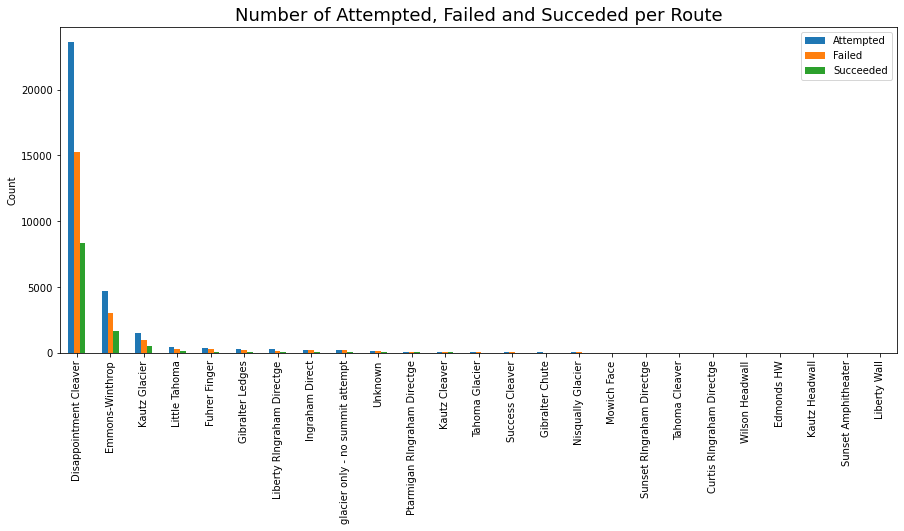

In [28]:
climb_data.groupby(['Route']).sum()[['Attempted', 'Failed', 'Succeeded']].sort_values('Attempted', ascending = False).plot.bar(figsize=(15,6))
plt.xlabel('Route')
plt.title('Number of Attempted, Failed and Succeded per Route', fontsize=18)
plt.xlabel('')
plt.ylabel('Count')

#Disappointment Cleaver by far the most popular route going by individual attempts, successes or failures.
#Unknown attempts neglibible considering the total number of attempts, successes or failures

<AxesSubplot:xlabel='Route'>

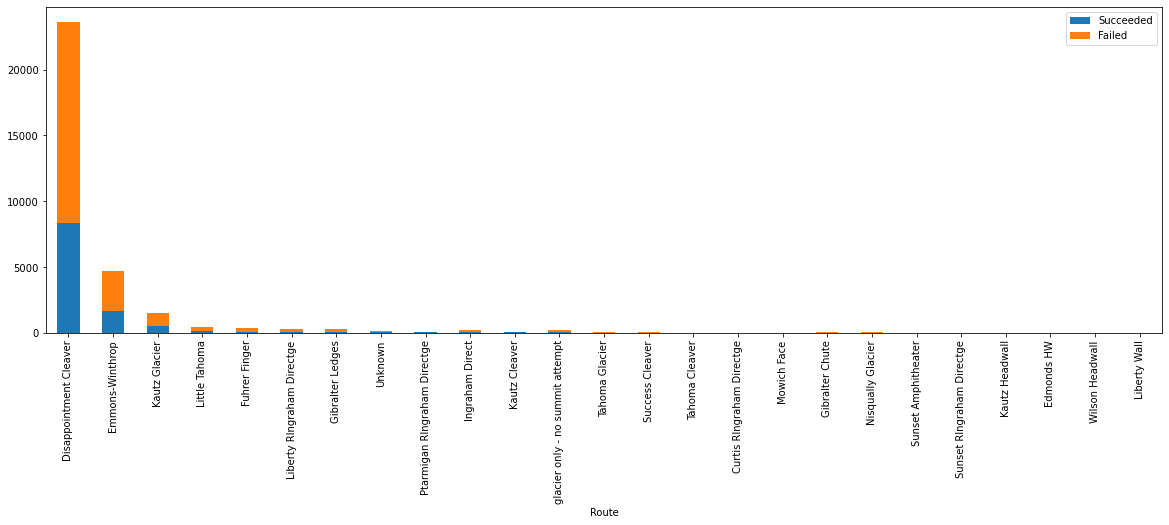

In [29]:
climb_data.groupby(['Route']).sum()[['Succeeded', 'Failed']].sort_values('Succeeded', ascending = False).plot.bar(stacked=True, figsize=(20,6))


<AxesSubplot:xlabel='Route'>

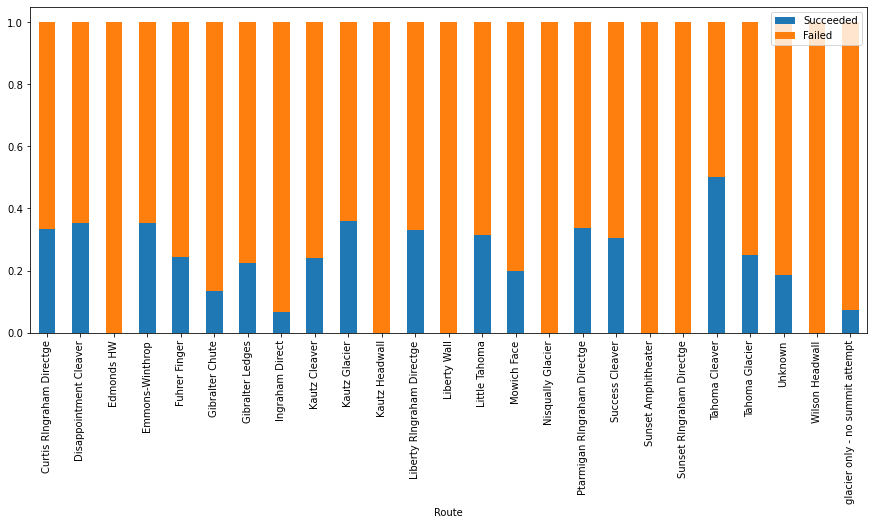

In [30]:
climb_data.groupby(['Route']).sum()[['Succeeded', 'Failed']].apply(lambda r: r/r.sum(), axis=1).plot.bar(stacked=True, figsize=(15,6))

Text(0.5, 1.0, 'Success Rate based on Individual Attempts')

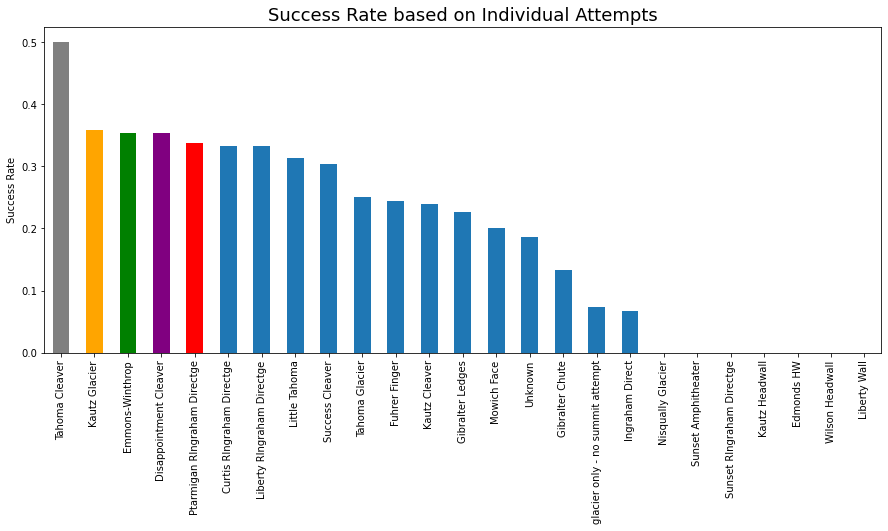

In [31]:
# create new datafram in order to be able to sort on success rate.
climb_data_route = climb_data.groupby(['Route']).sum()
climb_data_route['SuccessRate'] = climb_data_route['Succeeded'] / climb_data_route['Attempted']

ax = climb_data_route['SuccessRate'].sort_values(ascending = False).plot.bar(stacked=True, figsize=(15,6))
ax.patches[0].set_facecolor('grey')
ax.patches[1].set_facecolor('orange')
ax.patches[2].set_facecolor('green')
ax.patches[3].set_facecolor('purple')
ax.patches[4].set_facecolor('red')

plt.ylabel('Success Rate')
plt.xlabel('')
plt.title('Success Rate based on Individual Attempts', fontsize=18)

Text(0.5, 1.0, 'Success Rate based on Parties')

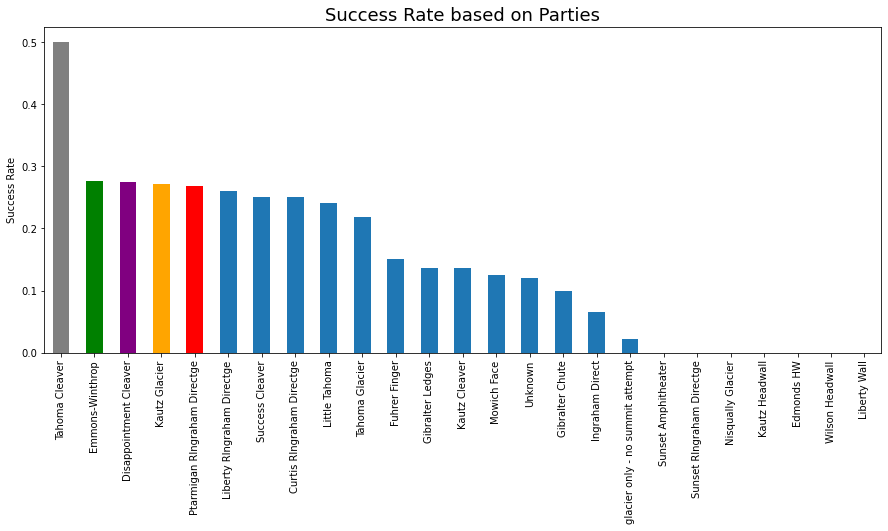

In [32]:
ax = climb_data.groupby(['Route']).mean()[['SuccessRate']].sort_values('SuccessRate', ascending = False).plot.bar(stacked=True, figsize=(15,6), legend=False)
ax.patches[0].set_facecolor('grey')
ax.patches[1].set_facecolor('green')
ax.patches[2].set_facecolor('purple')
ax.patches[3].set_facecolor('orange')
ax.patches[4].set_facecolor('red')

plt.ylabel('Success Rate')
plt.xlabel('')
plt.title('Success Rate based on Parties', fontsize=18)

In [33]:
climb_data_agg = climb_data.groupby(['Route', 'Date'], as_index=False).sum()
climb_data_agg['SuccessRate'] = climb_data_agg['Succeeded'] / climb_data_agg['Attempted']

In [34]:
climb_data_agg.head(15)

,Route,Date,Failed,Succeeded,Attempted,SuccessRate
0,Curtis RIngraham Directge,2015-05-29,2,0,2,0.000000
1,Curtis RIngraham Directge,2015-06-12,2,2,4,0.500000
2,Disappointment Cleaver,2014-01-05,2,0,2,0.000000
3,Disappointment Cleaver,2014-01-06,16,0,16,0.000000
4,Disappointment Cleaver,2014-02-10,16,0,16,0.000000
5,Disappointment Cleaver,2014-02-22,5,0,5,0.000000
6,Disappointment Cleaver,2014-02-28,2,0,2,0.000000
7,Disappointment Cleaver,2014-03-10,17,13,30,0.433333
8,Disappointment Cleaver,2014-04-05,8,0,8,0.000000
9,Disappointment Cleaver,2014-04-13,13,0,13,0.000000


Text(0.5, 1.0, 'Success Rate based on Daily Success Rates')

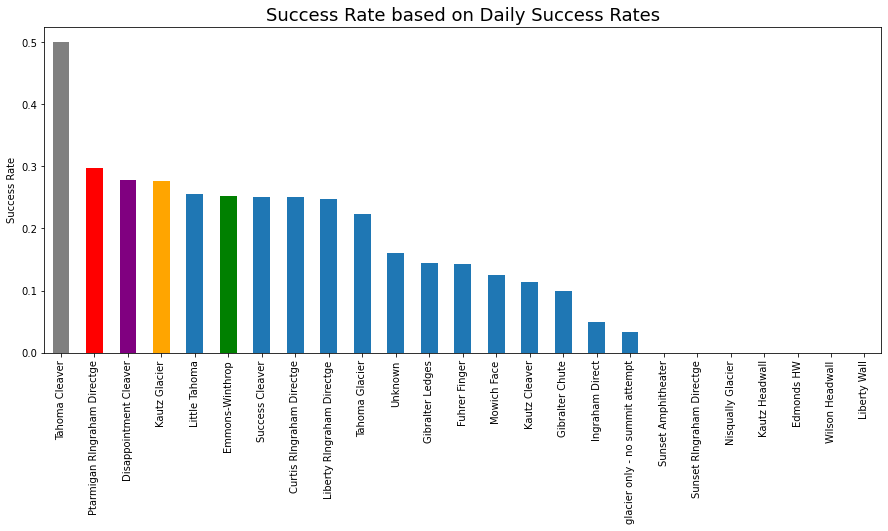

In [35]:
ax = climb_data_agg.groupby(['Route']).mean()[['SuccessRate']].sort_values('SuccessRate', ascending = False).plot.bar(stacked=True, figsize=(15,6), legend=False)
ax.patches[0].set_facecolor('grey')
ax.patches[1].set_facecolor('red')
ax.patches[2].set_facecolor('purple')
ax.patches[3].set_facecolor('orange')
ax.patches[5].set_facecolor('green')
plt.ylabel('Success Rate')
plt.xlabel('')
plt.title('Success Rate based on Daily Success Rates', fontsize=18)

In [36]:
climb_data.groupby(['Route']).sum()[['Succeeded', 'Failed']].sort_values('Route', ascending = True).apply(lambda r: r/r.sum(), axis=1)

,Succeeded,Failed
Route,,
Curtis RIngraham Directge,0.333333,0.666667
Disappointment Cleaver,0.353761,0.646239
Edmonds HW,0.000000,1.000000
Emmons-Winthrop,0.354374,0.645626
Fuhrer Finger,0.243767,0.756233
Gibralter Chute,0.133333,0.866667
Gibralter Ledges,0.225681,0.774319
Ingraham Direct,0.066390,0.933610
Kautz Cleaver,0.238806,0.761194


In [37]:
climb_data_route

,Failed,Succeeded,Attempted,SuccessRate
Route,,,,
Curtis RIngraham Directge,4,2,6,0.333333
Disappointment Cleaver,15259,8353,23612,0.353761
Edmonds HW,4,0,4,0.000000
Emmons-Winthrop,3048,1673,4721,0.354374
Fuhrer Finger,273,88,361,0.243767
Gibralter Chute,13,2,15,0.133333
Gibralter Ledges,199,58,257,0.225681
Ingraham Direct,225,16,241,0.066390
Kautz Cleaver,51,16,67,0.238806


In [38]:
climb_data.groupby(['Route']).mean()[['SuccessRate']].sort_values('Route', ascending = True)

,SuccessRate
Route,
Curtis RIngraham Directge,0.250000
Disappointment Cleaver,0.274620
Edmonds HW,0.000000
Emmons-Winthrop,0.276313
Fuhrer Finger,0.150906
Gibralter Chute,0.100000
Gibralter Ledges,0.136244
Ingraham Direct,0.066038
Kautz Cleaver,0.135714


In [39]:
climb_data_agg.groupby(['Route']).mean()[['SuccessRate']].sort_values('Route', ascending = True)

,SuccessRate
Route,
Curtis RIngraham Directge,0.250000
Disappointment Cleaver,0.278210
Edmonds HW,0.000000
Emmons-Winthrop,0.251428
Fuhrer Finger,0.142679
Gibralter Chute,0.100000
Gibralter Ledges,0.143961
Ingraham Direct,0.048810
Kautz Cleaver,0.113636
